# Apps Analysis

## 0. Data preprocessing

In [1]:
# Load library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from datetime import datetime
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as stm
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.mediation import Mediation
import os

path = os.getcwd()

# Manage warnings
pd.set_option('mode.chained_assignment', None)

# Import excel files
Data_1 = pd.read_excel(r'./Datasets/Data_1.xlsx')
Data_2 = pd.read_excel(r'./Datasets/Data_2.xlsx')
Data_3 = pd.read_excel(r'./Datasets/Data_3.xlsx')
Data_4 = pd.read_excel(r'./Datasets/Data_4.xlsx')
Personality = pd.read_excel(r'./Datasets/Part_Personality.xlsx')

# Create a new ID column common to all datasets
for i in [Data_1, Data_2, Data_3, Data_4, Personality]:
    # concatenate 'Probanden_ID' and 'lfdn' to create a new unique variable
    # which identify the combination participant-app
    i['Probanden_ID__lfdn'] = i.Probanden_ID.astype(str) + '__' + \
                                  i.lfdn.astype(str)

# Create a new ID column which uniquely identify observations
# on Data_1, Data_2, Data_3, Data_4

# (PS. There are persons with the same initials and apps number
# so the progressive number is necessary)
for i in [Data_1, Data_2, Data_3, Data_4]:
    # concatenate 'Probanden_ID', 'lfdn' and 'AppNr' to create a new variable
    # which identify uniquely each observations
    i['Probanden_ID__lfdn__AppNr'] = i.Probanden_ID.astype(str) + '__' + \
                                     i.lfdn.astype(str) + '__' + \
                                     i.AppNr.astype(str)
    # delete redundant columns
    i.drop(['AppNr', 'lfdn', 'Probanden_ID'], axis=1, inplace=True)

# Check if V1 is the same in all 4 datasets for the combination
# participant + progressive number + app number

# list of dataframes with only the columns under investigation
dataframe_list = [Data_1[['Probanden_ID__lfdn__AppNr', 'V1']],
                  Data_2[['Probanden_ID__lfdn__AppNr', 'V1']],
                  Data_3[['Probanden_ID__lfdn__AppNr', 'V1']],
                  Data_4[['Probanden_ID__lfdn__AppNr', 'V1']]]

# reduce cumulatively compute a function on a list and return the result
V1_merge = reduce(lambda left, right: pd.merge(left, right,
                                               on='Probanden_ID__lfdn__AppNr'),
                  dataframe_list)

# Check all columns against the first column using 'eq'
V1_merge = V1_merge.fillna('-')
# 'all' make sure that all the value along the columns are true
# if sum equal to number rows then V1 is the same for all datasets
sum(V1_merge.filter(like='V1').eq(V1_merge.iloc[:, 1],
                                  axis=0).all(axis=1)) == Data_1.shape[0]

# Since they are all the same drop V1 from other datasets
for i in [Data_2, Data_3, Data_4]:
    i.drop('V1', axis=1, inplace=True)

# Rename cols before merging adding the number of the interview
# which is refering too
for num, data in enumerate([Data_1, Data_2, Data_3, Data_4]):
    for col_name in ['Datum', 'Interviewer', 'V4', 'V5', 'V6', 'V12',
                     'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23']:
        if any(data.columns == col_name):
            data.rename(columns={col_name: col_name +
                                 '_' + str(num + 1) +
                                 '_Interview'}, inplace=True)

# Merge datasets
for i in [Data_2, Data_3, Data_4]:
    i.drop('Probanden_ID__lfdn', axis=1, inplace=True)

dataframe_list = [Data_1, Data_2, Data_3, Data_4]

Apps = reduce(lambda left, right: pd.merge(left, right,
                                           on='Probanden_ID__lfdn__AppNr'),
              dataframe_list)

# Reorder columns
col = ['Probanden_ID__lfdn__AppNr', 'Probanden_ID__lfdn', 'Datum_1_Interview',
       'Datum_2_Interview', 'Datum_3_Interview', 'Datum_4_Interview',
       'Interviewer_1_Interview', 'Interviewer_2_Interview',
       'Interviewer_3_Interview', 'Interviewer_4_Interview', 'V1',
       'V01', 'V2', 'V3', 'V4_1_Interview', 'V4_2_Interview', 'V4_3_Interview',
       'V4_4_Interview', 'V5_1_Interview', 'V5_2_Interview', 'V5_3_Interview',
       'V5_4_Interview', 'V6_1_Interview', 'V6_2_Interview', 'V6_3_Interview',
       'V6_4_Interview', 'V7', 'V8', 'V9', 'V10', 'V11', 'Kombi',
       'V12_1_Interview', 'V12_2_Interview', 'V12_3_Interview',
       'V12_4_Interview', 'V13', 'V14', 'V17_2_Interview',
       'V17_3_Interview', 'V17_4_Interview', 'V18_2_Interview',
       'V18_3_Interview', 'V18_4_Interview', 'V19_2_Interview',
       'V19_3_Interview', 'V19_4_Interview', 'V20_2_Interview',
       'V20_3_Interview', 'V20_4_Interview', 'V21_2_Interview',
       'V21_3_Interview', 'V21_4_Interview', 'V22_2_Interview',
       'V23_2_Interview']

Apps = Apps[col]

# Calculate the percentage of missing for each row
# delete the row with high number of missing values(>80%)
values_over_rows = Apps.apply(lambda x: x.count(), axis=1)
Apps['Miss_row_%'] = 100 - values_over_rows/len(Apps.columns)*100
Apps = Apps[Apps['Miss_row_%'] < 80]

# Calculate the percentage of missing for each columns
# delete the columns with high number of missing values (>80%)
miss_cols_pct = pd.DataFrame(100-(Apps.apply(lambda x: x.count(), axis=0) /
                                  Apps.shape[0])*100)
col_del = list(miss_cols_pct[miss_cols_pct[0] > 80].index)  # V8, V9, Kombi
Apps.drop(col_del, axis=1, inplace=True)

# Format date
# Datum_1 filter out the date with a point between them
typo_row_index = []
typo_date = []

for row in list(Apps.index):
    # convert date on the format '03.01.2018'
    if len(str(Apps.loc[row, 'Datum_1_Interview'])) == 10:
        Apps.loc[row, 'Datum_1_Interview'] = \
            datetime.strptime(Apps.loc[row, 'Datum_1_Interview'],
                              '%d.%m.%Y')
    # convert date on the format '43037'
    elif len(str(Apps.loc[row, 'Datum_1_Interview'])) == 5:
        Apps.loc[row, 'Datum_1_Interview'] = \
            datetime.fromordinal(datetime(1900, 1, 1).toordinal() +
                                 int(Apps.loc[row, 'Datum_1_Interview']) - 2)
    elif pd.isna(Apps.loc[row, 'Datum_1_Interview']):
        pass  # do nothing
    else:  # write down the typos
        typo_row_index.append(row)
        typo_date.append(Apps.loc[row, 'Datum_1_Interview'])

# Adjust for typos
np.unique(typo_date)
for row in typo_row_index:
    Apps.loc[row, 'Datum_1_Interview'] = datetime(2017, 12, 20)

# Adjst date_2_interview
typo_row_index = []
typo_date = []

for row in list(Apps.index):
    # convert date on the format '03.01.2018'
    if len(str(Apps.loc[row, 'Datum_2_Interview'])) == 10:
        Apps.loc[row, 'Datum_2_Interview'] = \
            datetime.strptime(Apps.loc[row, 'Datum_2_Interview'],
                              '%d.%m.%Y')
    # if already in timestamp format
    elif isinstance(Apps.loc[row, 'Datum_2_Interview'], datetime):
        pass  # do nothing
    elif pd.isna(Apps.loc[row, 'Datum_2_Interview']):
        pass  # do nothing
    else:  # write down the typos
        typo_row_index.append(row)
        typo_date.append(Apps.loc[row, 'Datum_2_Interview'])

# Adjst for date_3_interview
typo_row_index = []
typo_date = []

for row in list(Apps.index):
    # If it is already an instance of datetime do nothing
    if isinstance(Apps.loc[row, 'Datum_3_Interview'], datetime):
        pass
    # convert date on the format '03.01.2018'
    elif len(str(Apps.loc[row, 'Datum_3_Interview'])) == 10 and \
            Apps.loc[row, 'Datum_3_Interview'].find('.') > 0:
        Apps.loc[row, 'Datum_3_Interview'] = \
            datetime.strptime(Apps.loc[row, 'Datum_3_Interview'],
                              '%d.%m.%Y')
    # convert date on the format '17/05/2018'
    elif len(str(Apps.loc[row, 'Datum_3_Interview'])) == 10 and \
            Apps.loc[row, 'Datum_3_Interview'].find('/') > 0:
        Apps.loc[row, 'Datum_3_Interview'] = \
            datetime.strptime(Apps.loc[row, 'Datum_3_Interview'],
                              '%d/%m/%Y')
    # If it is already in timestamp pass
    elif pd.isna(Apps.loc[row, 'Datum_3_Interview']):
        pass  # do nothing
    else:  # write down any other typos
        typo_row_index.append(row)
        typo_date.append(Apps.loc[row, 'Datum_3_Interview'])

# Adjst for date_4_interview
typo_row_index = []
typo_date = []

for row in list(Apps.index):
    # It is already an instance of datetime pass
    if isinstance(Apps.loc[row, 'Datum_4_Interview'], datetime):
        pass
    # convert date on the format '03.01.2018'
    elif len(str(Apps.loc[row, 'Datum_4_Interview'])) == 10 and \
            Apps.loc[row, 'Datum_4_Interview'].find('.') > 0:
        Apps.loc[row, 'Datum_4_Interview'] = \
            datetime.strptime(Apps.loc[row, 'Datum_4_Interview'],
                              '%d.%m.%Y')
    # convert date on the format '17/05/2018'
    elif len(str(Apps.loc[row, 'Datum_4_Interview'])) == 10 and \
            Apps.loc[row, 'Datum_4_Interview'].find('/') > 0:
        Apps.loc[row, 'Datum_4_Interview'] = \
            datetime.strptime(Apps.loc[row, 'Datum_4_Interview'],
                              '%d/%m/%Y')
    # If it is missing
    elif pd.isna(Apps.loc[row, 'Datum_4_Interview']):
        pass
    else:  # write down the typos
        typo_row_index.append(row)
        typo_date.append(Apps.loc[row, 'Datum_4_Interview'])


# Check if the interviews are progressive
Apps['Days_Between_2_and_1_Interview'] = Apps['Datum_2_Interview'] - \
                                                Apps['Datum_1_Interview']

# correct the typo with year 2108 in Datum_2_Interview
Apps.loc[Apps['Datum_2_Interview'] > datetime(2020, 1, 1),
         'Datum_2_Interview'] = datetime(2018, 4, 11)

# Update calculation
Apps['Days_Between_2_and_1_Interview'] = Apps['Datum_2_Interview'] - \
                                                Apps['Datum_1_Interview']

# Transform the calculation into numbers of days
Apps['Days_Between_2_and_1_Interview'] = \
        Apps['Days_Between_2_and_1_Interview'].apply(lambda x:
                                                     x.total_seconds() /
                                                     60/60/24)

# Difference between 3 and 2 interview
Apps['Days_Between_3_and_2_Interview'] = Apps['Datum_3_Interview'] - \
                                                Apps['Datum_2_Interview']

# Spot typos
pd.unique(Apps.loc[Apps['Datum_3_Interview'] > datetime(2020, 1, 1),
                   'Datum_3_Interview'])
# (2918, 2, 3, 0, 0)
Apps.loc[Apps['Datum_3_Interview'] > datetime(2500, 1, 1),
         'Datum_3_Interview'] = datetime(2018, 2, 3)

# (2020, 5, 17, 0, 0)
Apps.loc[Apps['Datum_3_Interview'] > datetime(2020, 1, 1),
         'Datum_3_Interview'] = datetime(2018, 5, 17)

# Did we have collection of data also during the 2019?
Apps.loc[Apps['Datum_3_Interview'] > datetime(2019, 1, 1),
         'Datum_3_Interview'] = datetime(2018, 5, 17)

Apps['Days_Between_3_and_2_Interview'] = Apps['Datum_3_Interview'] - \
                                                Apps['Datum_2_Interview']

# Into numbers of days
Apps['Days_Between_3_and_2_Interview'] = \
        Apps['Days_Between_3_and_2_Interview'].apply(lambda x:
                                                     x.total_seconds() /
                                                     60/60/24)

# Difference between 4 and 3 interview
Apps['Days_Between_4_and_3_Interview'] = Apps['Datum_4_Interview'] - \
                                                Apps['Datum_3_Interview']

# Spot typos
pd.unique(Apps.loc[Apps['Datum_4_Interview'] > datetime(2020, 1, 1),
                   'Datum_4_Interview'])

# datetime(3018, 3, 4, 0, 0)
Apps.loc[Apps['Datum_4_Interview'] > datetime(2500, 1, 1),
         'Datum_4_Interview'] = datetime(2018, 3, 4)

# Update calculation
Apps['Days_Between_4_and_3_Interview'] = Apps['Datum_4_Interview'] - \
                                                Apps['Datum_3_Interview']

# Find the date after 01/01/2019
np.unique(Apps.loc[Apps['Datum_4_Interview'] > datetime(2019, 1, 1),
          'Datum_4_Interview'])

# Change 2019-07-09 to 2018-07-09
Apps.loc[Apps['Datum_4_Interview'] > datetime(2019, 1, 1),
         'Datum_4_Interview'] = datetime(2018, 7, 9)

# Update the calcualtion
Apps['Days_Between_4_and_3_Interview'] = Apps['Datum_4_Interview'] - \
                                                Apps['Datum_3_Interview']

# Trasform the calculation into numbers of days
Apps['Days_Between_4_and_3_Interview'] = \
        Apps['Days_Between_4_and_3_Interview'].apply(lambda x:
                                                     x.total_seconds() /
                                                     60/60/24)

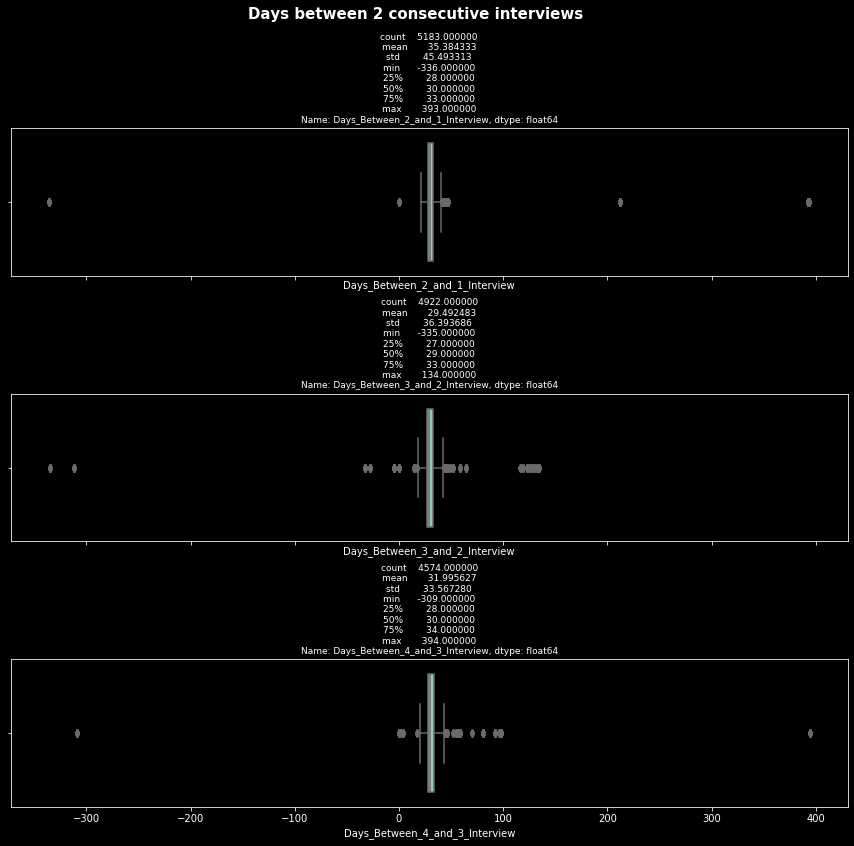

In [2]:
# Plot the different frequency graphs
descriptive_2_1 = pd.DataFrame.describe(Apps['Days_Between_2_and_1_Interview'])
descriptive_3_2 = pd.DataFrame.describe(Apps['Days_Between_3_and_2_Interview'])
descriptive_4_3 = pd.DataFrame.describe(Apps['Days_Between_4_and_3_Interview'])

fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(15, 13))
fig.suptitle('Days between 2 consecutive interviews',
             fontsize=15, fontweight='bold')
sns.boxplot(Apps['Days_Between_2_and_1_Interview'].dropna(),
            ax=axs[0])
axs[0].set_title('{}'.format(descriptive_2_1), fontsize=9)
sns.boxplot(Apps['Days_Between_3_and_2_Interview'].dropna(),
            ax=axs[1])
axs[1].set_title('{}'.format(descriptive_3_2), fontsize=9)
sns.boxplot(Apps['Days_Between_4_and_3_Interview'].dropna(),
            ax=axs[2])
axs[2].set_title('{}'.format(descriptive_4_3), fontsize=9)
fig.subplots_adjust(top=0.85, hspace=0.8)
plt.show()


**COMMENT:** <br />
Most of the observations are within 1 month apart between two consecutive interviews. <br />
There are some outiers (e.g. -300 or 400 days apart) which are assumed to be due to data entry errors or typos. <br />

#### The cell below adjust some of these typos.

In [3]:
# KK_5__278 >> 2018 - 2017 - 2017 - 2018
# chenge the middle two dates
Apps.loc[Apps['Datum_2_Interview'] == datetime(2017, 5, 13),
         'Datum_2_Interview'] = datetime(2018, 5, 13)
Apps['Days_Between_2_and_1_Interview'] = Apps['Datum_2_Interview'] - \
                                                Apps['Datum_1_Interview']
# Into numbers of days
Apps['Days_Between_2_and_1_Interview'] = \
        Apps['Days_Between_2_and_1_Interview'].apply(lambda x:
                                                     x.total_seconds() /
                                                     60/60/24)

# Continuos to fix typos
# Think what to do do with the missing date
# (assumption there is a progression within the interviews so keep it)
# TODO

# Delete Interviewer columns
Apps.drop(['Interviewer_1_Interview', 'Interviewer_2_Interview',
           'Interviewer_3_Interview', 'Interviewer_4_Interview'],
          axis=1, inplace=True)

# Delete rows with both V1 and V01 missing, thus no apps listed
# (V01 can be create base on value in V1)

V1_V01_miss_idx = list(Apps.loc[(Apps['V1'].isna()) &
                       (Apps['V01'].isna())].index)

Apps.drop(V1_V01_miss_idx, axis=0, inplace=True)

# check V2 frequency and missing
pd.value_counts(Apps['V2'])

# Eliminate 3,4, 6 values
V2_outbound_idx = list(Apps.loc[Apps['V2'].isin([3, 4, 6])].index)
Apps.drop(V2_outbound_idx, axis=0, inplace=True)

# V3 check missing and frequency
pd.value_counts(Apps['V3'])
V3_outbound_idx = list(Apps.loc[Apps['V3'] == 5].index)
Apps.drop(V3_outbound_idx, axis=0, inplace=True)

# V4_1_Interview check missing and frequency (1++ - 7--)
pd.value_counts(Apps['V4_1_Interview'])
V4_1_outbound_idx = list(Apps.loc[Apps['V4_1_Interview'] == 11].index)
Apps.drop(V4_1_outbound_idx, axis=0, inplace=True)

# V4_2_Interview check missing and frequency (1++ - 7--)
pd.value_counts(Apps['V4_2_Interview'])
V4_2_outbound_idx = list(Apps.loc[(Apps['V4_2_Interview'] > 7)].index)
Apps.drop(V4_2_outbound_idx, axis=0, inplace=True)

# V4_3_Interview check missing and frequency (1++ - 7--)
pd.value_counts(Apps['V4_3_Interview'])
V4_3_outbound_idx = list(Apps.loc[(Apps['V4_3_Interview'] > 7)].index)
Apps.drop(V4_3_outbound_idx, axis=0, inplace=True)

# V4_4_Interview check missing and frequency (1++ - 7--)
pd.value_counts(Apps['V4_4_Interview'])
V4_4_outbound_idx = list(Apps.loc[(Apps['V4_4_Interview'] > 7)].index)
Apps.drop(V4_4_outbound_idx, axis=0, inplace=True)

# V5 > different unit of measurement together delete columns

Apps.drop(['V5_1_Interview', 'V5_2_Interview',
           'V5_3_Interview', 'V5_4_Interview'], axis=1, inplace=True)

# V6 (1 -10) - check out of bound values
Apps.loc[:, ['V6_1_Interview', 'V6_2_Interview',
             'V6_3_Interview', 'V6_4_Interview']].apply(pd.Series.value_counts)

for i in ['V6_1_Interview', 'V6_2_Interview',
          'V6_3_Interview', 'V6_4_Interview']:
    V6_outbound_idx = list(Apps.loc[(Apps[i] > 10)].index)
    Apps.drop(V6_outbound_idx, axis=0, inplace=True)

# V7 delete
Apps.drop(['V7'], axis=1, inplace=True)

# V10 extended function (1 - 10)
pd.value_counts(Apps['V10'])
V10_outbound_idx = list(Apps.loc[(Apps['V10'] > 10)].index)
Apps.drop(V10_outbound_idx, axis=0, inplace=True)

# V11 use across apps
pd.value_counts(Apps['V11'])
V11_outbound_idx = list(Apps.loc[(Apps['V11'] > 10)].index)
Apps.drop(V11_outbound_idx, axis=0, inplace=True)

# V12 satisfaction (1-- - 10++)
Apps.loc[:, ['V12_1_Interview', 'V12_2_Interview',
             'V12_3_Interview',
             'V12_4_Interview']].apply(pd.Series.value_counts)

# V12 has 6 " " need to use coerce to transform it to null
Apps['V12_2_Interview'] = pd.to_numeric(Apps['V12_2_Interview'],
                                        errors='coerce')

# Transform categorical to float
Apps['V12_4_Interview'] = Apps['V12_4_Interview'].astype(float)

# Show summary
pd.DataFrame.describe(Apps.loc[:, ['V12_1_Interview', 'V12_2_Interview',
                                   'V12_3_Interview',
                                   'V12_4_Interview']], include='all')

for i in ['V12_1_Interview', 'V12_2_Interview',
          'V12_3_Interview', 'V12_4_Interview']:
    V12_outbound_idx = list(Apps.loc[(Apps[i] > 10)].index)
    Apps.drop(V12_outbound_idx, axis=0, inplace=True)

# V13 future use (1-- - 10++)
pd.value_counts(Apps['V13'])

# Delete outbounds observations
V13_outbound_idx = list(Apps.loc[(Apps['V13'] > 10)].index)
Apps.drop(V13_outbound_idx, axis=0, inplace=True)

# V14 future use (1-- - 10++)
pd.value_counts(Apps['V14'])

# Delete outboud observation
V14_outbound_idx = list(Apps.loc[(Apps['V14'] > 10)].index)
Apps.drop(V14_outbound_idx, axis=0, inplace=True)

# V17 habit
cols = ['V17_2_Interview', 'V17_3_Interview', 'V17_4_Interview']
Apps[cols].apply(pd.Series.value_counts)

# coerce " " (string na) to NaN (numeric na)
Apps[cols] = Apps[cols].apply(pd.to_numeric, errors='coerce')

Apps[cols].apply(lambda x: sum(x.isna()), axis=0)

# V18 Flow
cols = ['V18_2_Interview', 'V18_3_Interview', 'V18_4_Interview']
Apps[cols].apply(pd.Series.value_counts)

# coerce " " (string na) to NaN (numeric na)
Apps[cols] = Apps[cols].apply(pd.to_numeric, errors='coerce')
Apps[cols].apply(lambda x: sum(x.isna()), axis=0)

# V19 Confirmation
cols = ['V19_2_Interview', 'V19_3_Interview', 'V19_4_Interview']
Apps[cols].apply(pd.Series.value_counts)

# coerce " " (string na) to NaN (numeric na)
Apps[cols] = Apps[cols].apply(pd.to_numeric, errors='coerce')
Apps[cols].apply(lambda x: sum(x.isna()), axis=0)

# V20
cols = ['V20_2_Interview', 'V20_3_Interview', 'V20_4_Interview']
Apps[cols].apply(pd.Series.value_counts)
Apps[cols].apply(lambda x: sum(x.isna()), axis=0)

# V21
cols = ['V21_2_Interview', 'V21_3_Interview', 'V21_4_Interview']
Apps[cols].apply(pd.Series.value_counts)
Apps[cols].apply(lambda x: sum(x.isna()), axis=0)

# delete V22 V23
Apps.drop(['V22_2_Interview', 'V23_2_Interview'], axis=1, inplace=True)

# Drop rows with na
Apps_clean = Apps.dropna()

# Create the final csv file
# Apps_clean.to_csv('Apps_clean.csv')
# Read the file into the workspace
# Apps_clean = pd.read_csv(r'./Apps_clean.csv')
